# Head

## imports

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function , division
from __future__ import absolute_import
from __future__ import unicode_literals

In [2]:
# %matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import random
from sklearn.metrics import confusion_matrix
from pylab import rcParams

from config import config

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, BatchNormalization, concatenate, Input
from keras import backend as K
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import ReLU
from keras.regularizers import l2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model , np_utils
from keras.models import model_from_json

import tensorflow as tf
from keras.backend import tensorflow_backend as K

## memoryの制限

In [3]:
# memoryの制限
m_config = tf.ConfigProto()
m_config.gpu_options.visible_device_list = "0"
m_config.gpu_options.per_process_gpu_memory_fraction = 0.5
m_config.gpu_options.allow_growth = True
sess = tf.Session(config=m_config)
K.set_session(sess)

In [4]:
#GPUを認識できてるか確認
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

## Tuning

In [5]:
#Tuning
dataset = config.DATASET
n_points = config.N_POINTS
cell = config.CELL
num_classes = config.NUM_CLASSES
extension = config.EXTENSION
batch_size = config.BATCH_SIZE
class_name = config.CLASS_NAME
optimizer = config.OPTIMIZER
epochs = config.EPOCHS
learning_rate = config.LEARNIG_RATE
callbacks = config.CALLBACKS

In [6]:
train_or_test = ["train","test"]

## Directory関連

In [7]:
#読み込み，書き込み用ディレクトリ
data_dir = config.DATA_DIR
vox_dir = config.VOX_DIR
fig_dir =  config.FIG_DIR
dist_dir = config.DIST_DIR
weights_dir = config.WEIGHTS_DIR
model_dir = config.MODEL_DIR

In [8]:
dir_list = [data_dir , vox_dir , fig_dir , dist_dir , weights_dir , model_dir ]
for directory in dir_list:
    if os.path.exists(directory) == False:
        os.makedirs(directory)

In [9]:
# TrainとTestのデータdirectory作成
for t in train_or_test:
    for cl in class_name:
        if os.path.exists(data_dir + cl + "/" + t + "/") == False:
            os.makedirs(data_dir + cl + "/" + t + "/")

# 関数

## ファイル読み込み

In [10]:
def load_off(filename):
    # read OFF file
    with open(filename,"r") as handle:
        off = handle.read().rstrip().split("\n")
        
    #OFFファイルが不正かどうか判定
    if off[0] != "OFF":
#         print("{} is broken!!".format(filename))
        params = list(off[0].split(" "))
        n_vertices = int(params[0].strip("OFF"))
        n_faces = int(params[1])
        off.insert(0, "OFF")
    
    else:
        #get params and faces
        params = list(map(int, off[1].split(" ")))
        n_vertices = params[0]
        n_faces = params[1]

    # read  Vertex coordinates
    vertices = []
    for n in range(n_vertices):
        coords = list(map(float, off[2+n].split()))
        vertices.append(coords)

    # read information of faces
    faces = []
    for n in range(n_faces):
        connects = list(map(int, off[2 + n_vertices + n].split(" ")[1:4]))
        faces.append(connects)

    return vertices, faces

In [11]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

In [12]:
def get_index_2d_list(retrieval_object,array):
    return [i for i, x in enumerate(retrieval_object) if x == array][0]

In [13]:
def load_stl(filename):
    # read STL file
    with open(filename,"r") as handle:
        stl = handle.read().rstrip().split("\n")
        
    #get vertice
    vertice = []
    for i in range(len(stl)):
        pool = stl[i].split()
        if pool[0] == "vertex":
            vertex = list(map(float, pool[1:]))
            vertice.append(vertex)
            
    unique_vertice = get_unique_list(vertice)
            
    #get faces
    faces = []
    for n in range(len(stl)):
        if stl[n].split() == ['outer', 'loop']:
            indexes = []
            for i in range(3):
                index = get_index_2d_list(unique_vertice, list(map(float,stl[n+i+1].split()[1:])))
                indexes.append(index)
            faces.append(indexes)

    return unique_vertice, faces

## 点群発生系

In [14]:
def gen_random_points(vertices, faces, n_points):
#     なんもわからん
    cum_areas = calc_cumulative_areas(vertices, faces)
    points = []
    for n in range(n_points):
        fid = random_select_face_id(cum_areas)
        r1 = math.sqrt(random.random())
        r2 = random.random()
        a = vertices[faces[fid][0]]
        b = vertices[faces[fid][1]]
        c = vertices[faces[fid][2]]
        xp = (1 - r1) * a[0] + r1 * (1 - r2) * b[0] + r1 * r2 * c[0]
        yp = (1 - r1) * a[1] + r1 * (1 - r2) * b[1] + r1 * r2 * c[1]
        zp = (1 - r1) * a[2] + r1 * (1 - r2) * b[2] + r1 * r2 * c[2]
        points.append([xp, yp, zp])
    return points

## 可視化ツール

In [15]:
def plot3D(np_pc):
    #3D表示
    fig = plt.figure(1,figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.scatter(np_pc[:,0], np_pc[:,1], np_pc[:,2],s = 2)
    ax.axis("equal")
    plt.show()

In [16]:
def plot_trihedral_figure_vox(np_pc):
    #Voxel版三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=10)
#         plt.xlim([-2,32]) 
#         plt.ylim([-2,32]) 
        plt.gca().set_aspect('equal')
        plt.show()

In [17]:
def plot_trihedral_figure(np_pc):
    #三面図
    a = 1
    for i in range(3):
        if i == 2:
            a = -2
        plt.scatter(np_pc[:,i],np_pc[:,i+a],s=2)
        plt.axis('equal')
        plt.show()

In [18]:
def plot_confusion_matrix(data, 
                          label,
                          classes=class_name,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    labels_pred = model.predict_classes(data,verbose=0)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), labels_pred)
    np.set_printoptions(precision=2)
    cm_normalize = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cnf_matrix.max() / 2
    
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    plt.savefig(fig_dir + 'Normalized_confusion_matrix.svg')
    plt.show()


## ボクセル系

In [19]:
def voxilize(np_pc,cell):
# ボクセル化した配列を返す
    max_dist = 0.0
    for it in range(0,3):
        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_

        #xyzで一番並行距離が大きいのを求める
        if dist > max_dist:
            max_dist = dist
            
    for it in range(0,3):

        # 最大値と最小値の距離を求める
        min_ = np.amin(np_pc[:,it])
        max_ = np.amax(np_pc[:,it])
        dist = max_-min_
        
        #中心座標を 0,0,0にセットする（原点が中心にくるようにする）
        np_pc[:,it] = np_pc[:,it] - dist/2 - min_

        #covered cell
        cls = cell - 3

        #ボクセル一個当たりのサイズを求める
        vox_sz = max_dist/(cls-1)

        #上で算出した値で各点を割る。これで各点は(-14, 14)の範囲の値になる
        np_pc[:,it] = np_pc[:,it]/vox_sz

        #各点が全て正の整数になるよう移動。これで各点は[0, 30]になる（多分）
        np_pc[:,it] = np_pc[:,it] + (cls-1)/2


    #整数にする
    np_pc = np.rint(np_pc).astype(np.uint32)


    #３０＊３０＊３０の配列を作り，点が存在する場合は1、存在しない場合は0を入力する。
    vox = np.zeros([cell-2,cell-2,cell-2])

    # (pc_x, pc_y, pc_z)にnp_pcの座標を代入する
    for (pc_x, pc_y, pc_z) in np_pc:

#     # 点が存在しても20%の確率で0とし、データにノイズを加え、汎用性を上げている
#     # ここ，ノイジーなデータの場合８０よりも小さい数字にしたほうがいいかもね？
#         if random.randint(0,100) < 80:
        vox[pc_x, pc_y, pc_z] = 1

    np_vox = np.zeros([1,cell,cell,cell,1])
    np_vox[0, 1:-1, 1:-1, 1:-1,0] = vox

    return np_vox

In [20]:
def voxel_scatter(np_vox):
# キレイに整形するやつ
    #空の配列を作る
    vox_scat = np.zeros([0,3], dtype= np.uint32)

    #32回
    for x in range(0,np_vox.shape[1]):
        #32回
        for y in range(0,np_vox.shape[2]):
            #32回
            for z in range(0,np_vox.shape[3]):
                #（ｘ，ｙ，ｚ）に１が入っていればその座標を返す
                if np_vox[0,x,y,z,0] == 1.0:
                    arr_tmp = np.zeros([1,3],dtype=np.uint32)
                    arr_tmp[0,:] = (x,y,z)
                    vox_scat = np.concatenate((vox_scat,arr_tmp))
    return vox_scat

## ボクセルの読み込み

In [21]:
def load_vox(filename):
    #shape(N,1,32,32,32)の配列を返す
    vertices, faces = load_stl(filename)
    points = gen_random_points(vertices, faces, n_points)
    # ValueError: sequence too large; cannot be greater than 32の回避策
    # list 2 numpy.ndarray
    pc = np.empty((len(points), len(points[0])))
    pc[:] = points
    vox = voxilize(pc,cell)

    return vox

## 距離の計算

In [22]:
# XYZ 長さの取得
def calc_dist(filename):
    vertices, faces = load_stl(filename)
    point =  np.array(vertices)
    dist = np.zeros(3)
    for i in range(0,3):
        min_ = np.amin(point[:,i])
        max_ = np.amax(point[:,i])
        dist_ = max_ - min_
        if dist_ < 0.001:
            dist_ = 0.001
        dist[i] = dist_
    return dist

In [23]:
def index_to_class(index):
    return class_name[label[index].argmax()]

# modelの定義

## init model

In [24]:
#inputの定義
conv_input = Input(shape=(32, 32, 32 ,1), dtype="float32", name="conv_input")
aspect_input = Input(shape=(2,), dtype="float32", name="aspect_input")

# Conv3D部
conv_output = Conv3D(32,5,padding='valid',strides=(2, 2, 2),activation="relu")(conv_input)

conv_output = Dropout(0.4)(conv_output)

conv_output = Conv3D(32,3,padding='valid',strides=(1, 1, 1),activation="relu")(conv_output)

# conv_output = BatchNormalization()(conv_output)

conv_output = MaxPooling3D(pool_size=(2, 2, 2),strides=None, padding='valid')(conv_output)

conv_output = Dropout(0.4)(conv_output)

conv_output = Flatten()(conv_output)

# output = Flatten()(conv_output)

# output = BatchNormalization()(conv_output)

# アスペクト比部
aspect_output = Dense(128)(aspect_input)

aspect_output = Dropout(0.4)(aspect_output)

output = concatenate([conv_output, aspect_output])


# output = Dense(1024, #128
#                     kernel_initializer="normal",
#                     activation='linear',
#                     )(output)

output = Dropout(0.5)(output)

output = Dense(528, #128
                    kernel_initializer="normal",
                    activation='linear',
                    )(output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

model = Model(inputs=[conv_input, aspect_input], outputs=output)

## モデルの保存

In [25]:
#モデルの保存
json_string = model.to_json()
open(model_dir+'model.json', 'w').write(json_string)

5095

## modelの読み込み

In [26]:
#モデルの読み込み
model_data = open("model/" + dataset + "/cell" + str(cell) + "/model.json").read()
model = model_from_json(model_data)

In [27]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

## モデル可視化

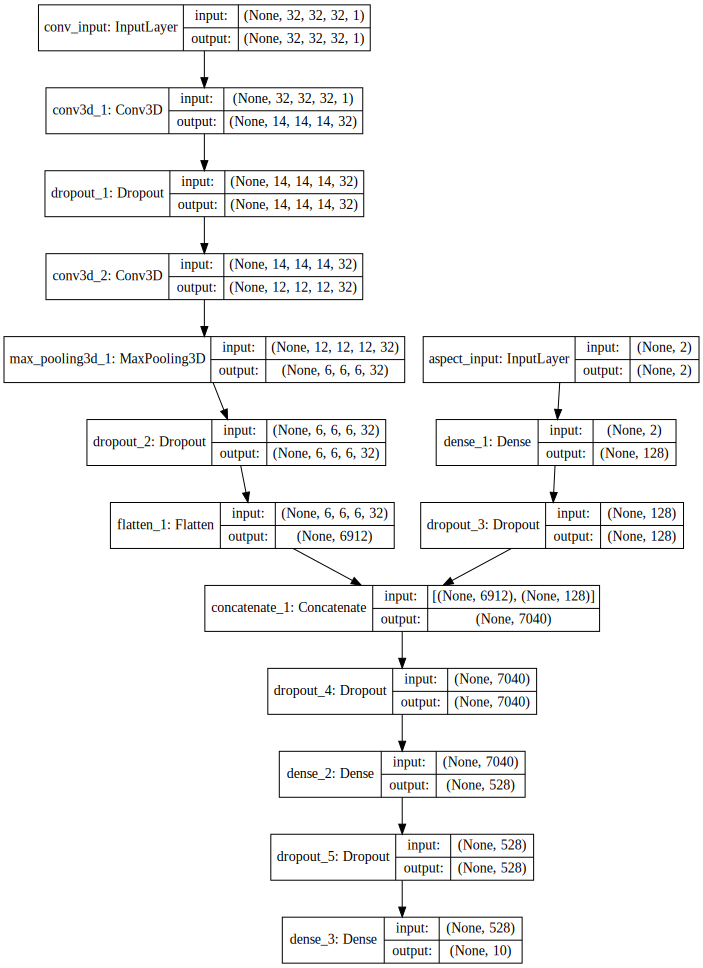

In [28]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [29]:
#モデルの図を保存
plot_model(model, to_file=fig_dir + 'model.png',show_shapes='True')

## summary

In [30]:
#サマリーの表示
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         (None, 32, 32, 32, 1 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 14, 14, 14, 3 4032        conv_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 14, 3 0           conv3d_1[0][0]                   
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 12, 12, 12, 3 27680       dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [31]:
model

# Train

## ボクセルのLoad

In [32]:
x_train = np.load( vox_dir  + "x_train.npy")
x_test = np.load( vox_dir  + "x_test.npy")
y_train = np.load( vox_dir + "y_train.npy")
y_test = np.load( vox_dir + "y_test.npy")

In [33]:
x_train.shape

(3991, 32, 32, 32, 1)

In [34]:
y_train.shape

(3991, 10)

In [35]:
x_test.shape

(908, 32, 32, 32, 1)

In [36]:
y_test.shape

(908, 10)

## アスペクト比のLoad

In [37]:
directory = dist_dir +"x_train.npy"

xyz = np.load(directory)
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
xy_ratio = y / x
xz_ratio = z / x
aspect_train =  np.stack([xy_ratio,xz_ratio],axis=1)

directory = dist_dir +"x_test.npy"

xyz = np.load(directory)
x = xyz[:,0]
y = xyz[:,1]
z = xyz[:,2]
xy_ratio = y / x
xz_ratio = z / x
aspect_test =  np.stack([xy_ratio,xz_ratio],axis=1)

In [38]:
aspect_train.shape

(3991, 2)

In [39]:
aspect_test.shape

(908, 2)

## fit

In [40]:
result = model.fit([x_train,aspect_train], y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=([x_test,aspect_test], y_test) ,
                   callbacks=callbacks)



Train on 3991 samples, validate on 908 samples
Epoch 1/40
3991/3991 [==============================] - 4s 1ms/step - loss: 1.2193 - acc: 0.6307 - val_loss: 0.7575 - val_acc: 0.7445
Epoch 2/40
3991/3991 [==============================] - 4s 937us/step - loss: 0.4841 - acc: 0.8447 - val_loss: 0.4604 - val_acc: 0.8392
Epoch 3/40
3991/3991 [==============================] - 4s 952us/step - loss: 0.3433 - acc: 0.8935 - val_loss: 0.3956 - val_acc: 0.8656
Epoch 4/40
3991/3991 [==============================] - 4s 901us/step - loss: 0.2690 - acc: 0.9110 - val_loss: 0.3647 - val_acc: 0.8756
Epoch 5/40
3991/3991 [==============================] - 4s 930us/step - loss: 0.2182 - acc: 0.9283 - val_loss: 0.3529 - val_acc: 0.8722
Epoch 6/40
3991/3991 [==============================] - 4s 929us/step - loss: 0.1874 - acc: 0.9354 - val_loss: 0.3212 - val_acc: 0.8932
Epoch 7/40
3991/3991 [==============================] - 4s 953us/step - loss: 0.1884 - acc: 0.9396 - val_loss: 0.3027 - val_acc: 0.8976
Epo

In [41]:
# # 重みの読み込み
# model.load_weights("weights/ModelNet10/cell32/weights__2018_11_29_15_46_12.h5")
# model.load_weights("weights/ModelNet40/cell32/weights__2018_12_29_16_15_51.h5")


# evaluate

In [42]:
loss,acc = model.evaluate([x_test,aspect_test], y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.33079952331124457
Test accuracy: 0.8986784143594918


In [43]:
# 重みを読み込んで評価
# model.load_weights("weights/"+dataset+"/cell32/model-38.h5")
# loss,acc = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', loss)
# print('Test accuracy:', acc)

## learning validation curve 

In [44]:
rcParams["figure.figsize"] = [6.4, 4.8]

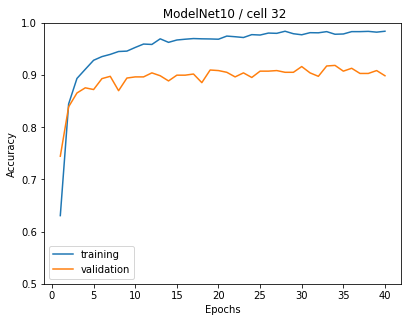

In [45]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc.svg')
plt.show()

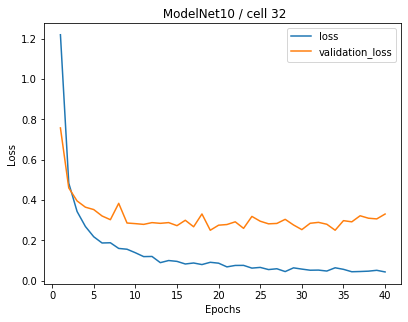

In [46]:
plt.plot(range(1, len(result.history['loss'])+1), result.history['loss'], label="loss")
plt.plot(range(1, len(result.history['val_loss'])+1), result.history['val_loss'], label="validation_loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir  + 'loss.svg')
plt.show()

## Confusion matrix

In [47]:
# labels_pred = model.predict_classes(x_test,verbose=0)

In [48]:
# labels_pred.shape

In [49]:
# labels_pred

In [50]:
# np.argmax(y_test, axis=1)

In [51]:
# 間違ったやつのIndex
# np.where((labels_pred == np.argmax(y_test, axis=1)) == 0)

In [52]:
# # グラフのサイズ
# rcParams['figure.figsize'] = 10,8


# # Plot normalized confusion matrix
# plot_confusion_matrix(x_test,y_test)


## 個別に分類

In [53]:
# vertices, faces = load_off(dataset+"/chair/train/0.off")
# points = gen_random_points(vertices, faces, n_points)
# # ValueError: sequence too large; cannot be greater than 32の回避策
# # list 2 numpy.ndarray
# test = np.empty((len(points), len(points[0])))
# test[:] = points
# print(type(test))
# #voxelize
# test_vox = voxilize(test,cell)

In [54]:
# model.load_weights('weights/'+dataset+'/cell32/model-40.h5')

# 読み込んだ学習済みモデルで予測
proba_all = model.predict([x_test,aspect_test])
print(proba_all)
proba = np.argmax(proba_all[0]) #ここの０がデータセットのindex
print(proba_all[0][proba])
print(class_name[proba])

[[9.8404402e-01 7.9215553e-08 4.3797736e-06 ... 1.3174486e-09
  1.7461156e-08 1.5949365e-02]
 [9.8931795e-01 4.2462869e-07 2.1586152e-08 ... 2.4983937e-08
  1.3148265e-05 1.4403957e-07]
 [9.9998903e-01 5.5652083e-07 9.2969728e-08 ... 6.8762734e-10
  2.3099221e-06 6.5098567e-07]
 ...
 [2.0979492e-08 4.5001815e-07 5.0013412e-08 ... 1.5459655e-09
  3.1052921e-11 9.9999952e-01]
 [3.4073119e-10 4.1501048e-07 5.4314184e-09 ... 8.2736262e-11
  5.0243351e-12 9.9999952e-01]
 [2.1033706e-09 8.6033874e-04 1.1028236e-06 ... 4.0756518e-09
  1.8136692e-12 9.9913847e-01]]
0.984044
bathtub


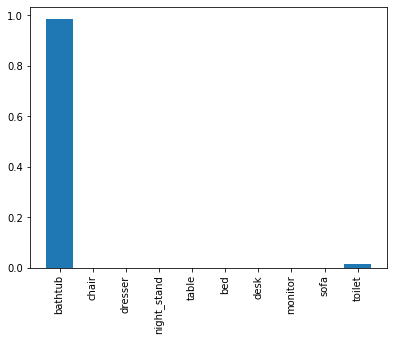

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(class_name , proba_all[0])
ax.set_xticklabels(class_name, rotation=90)
plt.show()

## アスペクト比の可視化

In [56]:
rcParams["figure.figsize"] = [12, 8]

/home/takitani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


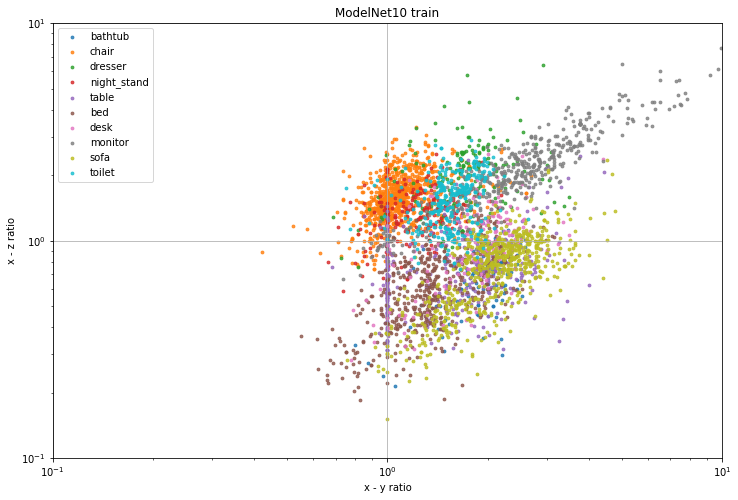

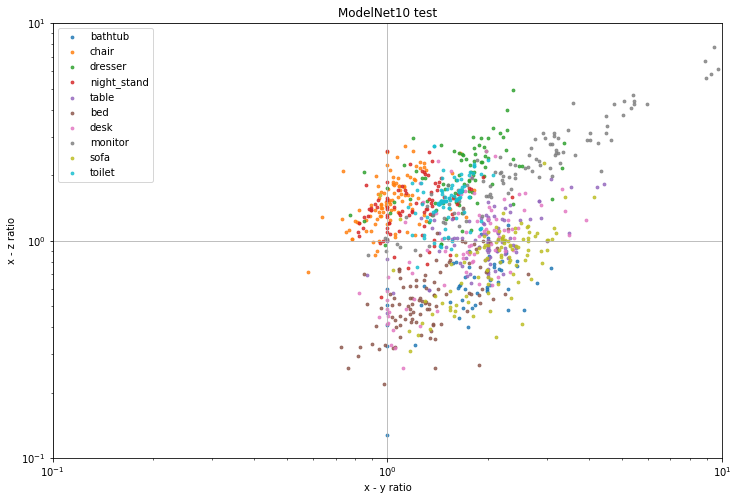

In [57]:
for t in train_or_test:
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for cl in class_name:
        directory = dist_dir + cl + t + ".npy"
        xyz = np.load(directory)
        x = xyz[:,0]
        y = xyz[:,1]
        z = xyz[:,2]
        xy_ratio = y / x
        xz_ratio = z / x
        ax.scatter(xy_ratio , xz_ratio, label=cl, s= 8, alpha=0.8)
        

    ax.set_title(dataset + " " + t)
    ax.set_xlabel('x - y ratio')
    ax.set_ylabel('x - z ratio')
#     plt.xlim([0.025,40])
#     plt.ylim([0.025,40])
    plt.xlim([0.1,10])
    plt.ylim([0.1,10])
    plt.xscale("log")
    plt.yscale("log")
    

    ax.grid(True)

    ax.legend(loc='upper left')
    fig.savefig(fig_dir + t + "_asp.svg")
    fig.show()

ラベル(index)を入力したらそのモデルのパスを返す関数

In [58]:
index = 3857
t_or_t = "train"
for i  in range(num_classes):
    cl = class_name[i]
    npy = np.load(dist_dir  + cl + t_or_t + ".npy")
    print(cl)
    print("index : ", index)
    index = index - len(npy) 
    print("npy : ", len(npy))
    print("=====================")
    if index < 0 :
        print(i)
        break

bathtub
index :  3857
npy :  106
chair
index :  3751
npy :  889
dresser
index :  2862
npy :  200
night_stand
index :  2662
npy :  200
table
index :  2462
npy :  392
bed
index :  2070
npy :  515
desk
index :  1555
npy :  200
monitor
index :  1355
npy :  465
sofa
index :  890
npy :  680
toilet
index :  210
npy :  344
9


# model構築２

In [59]:
loss,acc = model.evaluate([x_test,aspect_test], y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.33079952331124457
Test accuracy: 0.8986784143594918


In [60]:
range(1, len(result.history['acc'])+1)

range(1, 41)

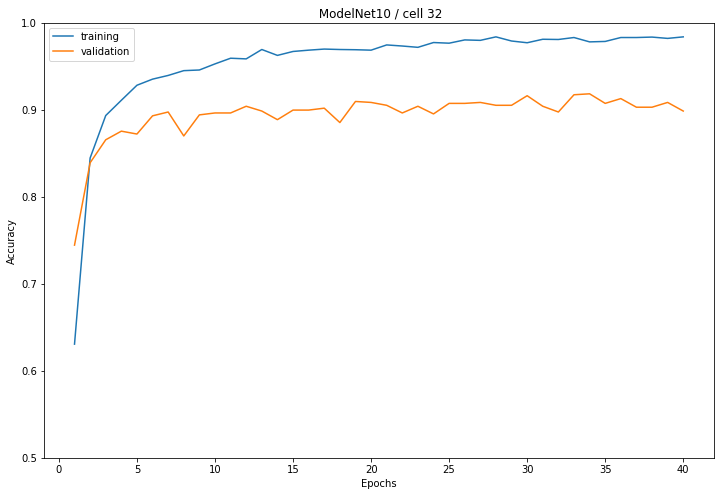

In [61]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc_1.svg')
plt.show()

In [62]:
#inputの定義
conv_input = Input(shape=(32, 32, 32 ,1), dtype="float32", name="conv_input")
aspect_input = Input(shape=(2,), dtype="float32", name="aspect_input")

# Conv3D部
conv_output = Conv3D(32,5,padding='valid',strides=(2, 2, 2),activation="relu")(conv_input)

conv_output = Dropout(0.4)(conv_output)

conv_output = Conv3D(32,3,padding='valid',strides=(1, 1, 1),activation="relu")(conv_output)

# conv_output = BatchNormalization()(conv_output)

conv_output = MaxPooling3D(pool_size=(2, 2, 2),strides=None, padding='valid')(conv_output)

conv_output = Dropout(0.4)(conv_output)

output = Flatten()(conv_output)

# output = BatchNormalization()(conv_output)

# output = Dense(1024, #128
#                     kernel_initializer="normal",
#                     activation='linear',
#                     )(output)

output = Dropout(0.5)(output)

output = Dense(528, #128
                    kernel_initializer="normal",
                    activation='linear',
                    )(output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

model = Model(inputs=conv_input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

result1 = model.fit(x_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(x_test, y_test) ,
                   callbacks=callbacks)

Train on 3991 samples, validate on 908 samples
Epoch 1/40
3991/3991 [==============================] - 4s 985us/step - loss: 1.1503 - acc: 0.6439 - val_loss: 0.5645 - val_acc: 0.8150
Epoch 2/40
3991/3991 [==============================] - 3s 790us/step - loss: 0.4187 - acc: 0.8707 - val_loss: 0.4742 - val_acc: 0.8568
Epoch 3/40
3991/3991 [==============================] - 3s 788us/step - loss: 0.3163 - acc: 0.8995 - val_loss: 0.4989 - val_acc: 0.8502
Epoch 4/40
3991/3991 [==============================] - 3s 743us/step - loss: 0.2729 - acc: 0.9121 - val_loss: 0.3766 - val_acc: 0.8645
Epoch 5/40
3991/3991 [==============================] - 3s 813us/step - loss: 0.2261 - acc: 0.9263 - val_loss: 0.3568 - val_acc: 0.8744
Epoch 6/40
3991/3991 [==============================] - 3s 804us/step - loss: 0.1815 - acc: 0.9371 - val_loss: 0.4115 - val_acc: 0.8480
Epoch 7/40
3991/3991 [==============================] - 3s 817us/step - loss: 0.1692 - acc: 0.9446 - val_loss: 0.3374 - val_acc: 0.8756
E

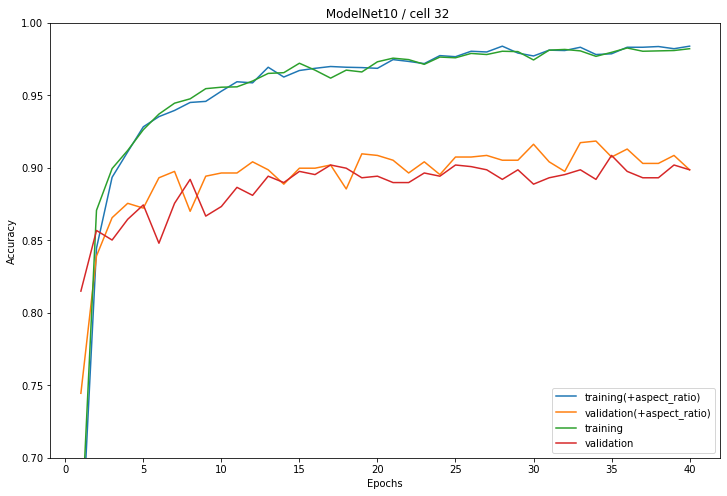

In [63]:
plt.plot(range(1, len(result.history['acc'])+1), result.history['acc'], label="training(+aspect_ratio)")
plt.plot(range(1, len(result.history['val_acc'])+1), result.history['val_acc'], label="validation(+aspect_ratio)")
plt.plot(range(1, len(result1.history['acc'])+1), result1.history['acc'], label="training")
plt.plot(range(1, len(result1.history['val_acc'])+1), result1.history['val_acc'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.7,1])
plt.legend()
plt.title(" {} / cell {}".format(dataset,cell))
plt.savefig(fig_dir + 'acc_1.png')
plt.show()

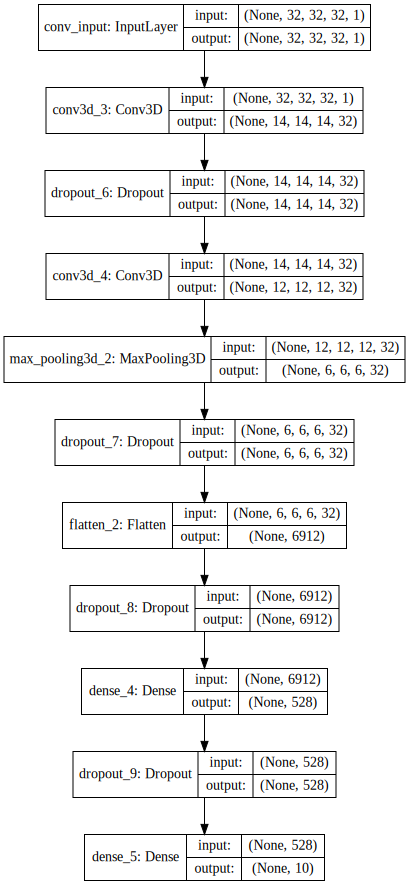

In [64]:
#モデル可視化
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [65]:
# npz = np.load("ModelNet40.npz")
# x_train = npz['train_voxel']
# x_train = x_train.reshape((-1,32,32,32,1))
# y_train = npz['train_label']
# x_test = npz['test_voxel']
# x_test = x_test.reshape((-1,32,32,32,1))
# y_test = npz['test_label']

# # convert label to one-hot-vector
# y_train = np_utils.to_categorical(y_train, 40)
# y_test = np_utils.to_categorical(y_test, 40)

In [66]:
# アスペクト比部
aspect_output = Dense(256)(aspect_input)

aspect_output = Dropout(0.4)(aspect_output)

output = Dense(128, #128
                    activation='linear',
                    kernel_initializer='normal',
                    )(aspect_output)

output = Dropout(0.5)(output)

output = Dense(num_classes, activation="softmax")(output)

In [67]:
model = Model(inputs=aspect_input, outputs=output)

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
aspect_input (InputLayer)    (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               768       
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 34,954
Trainable params: 34,954
Non-trainable params: 0
_________________________________________________________________


In [69]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

In [70]:
result = model.fit(aspect_train, y_train,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(aspect_test, y_test) ,
                   callbacks=callbacks)

Train on 3991 samples, validate on 908 samples
Epoch 1/40
3991/3991 [==============================] - 0s 101us/step - loss: 1.6663 - acc: 0.4307 - val_loss: 1.6890 - val_acc: 0.3998
Epoch 2/40
3991/3991 [==============================] - 0s 42us/step - loss: 1.3733 - acc: 0.5242 - val_loss: 1.5612 - val_acc: 0.4604
Epoch 3/40
3991/3991 [==============================] - 0s 42us/step - loss: 1.3500 - acc: 0.5405 - val_loss: 1.6280 - val_acc: 0.4108
Epoch 4/40
3991/3991 [==============================] - 0s 42us/step - loss: 1.3351 - acc: 0.5530 - val_loss: 1.5795 - val_acc: 0.4449
Epoch 5/40
3991/3991 [==============================] - 0s 42us/step - loss: 1.3302 - acc: 0.5497 - val_loss: 1.5646 - val_acc: 0.4548
Epoch 6/40
3991/3991 [==============================] - 0s 42us/step - loss: 1.3196 - acc: 0.5475 - val_loss: 1.5661 - val_acc: 0.4670
Epoch 7/40
3991/3991 [==============================] - 0s 44us/step - loss: 1.3260 - acc: 0.5570 - val_loss: 1.5787 - val_acc: 0.4350
Epoch 8

ボクセル化することによって概形が得られ，それにあまり差分がない？（クラスごとに）
Flagの調整